# Sentinel Hub - Sandbox

* [Requests Builder](https://apps.sentinel-hub.com/requests-builder/)
* [Sentinel Hub Python Process API](https://sentinelhub-py.readthedocs.io/en/latest/examples/process_request_cdse.html)
* [Sentinel Hub GitHub](https://github.com/sentinel-hub/sentinelhub-py)
* [Sentinel Hub `plot_image` function](https://github.com/sentinel-hub/sentinelhub-py/blob/master/examples/utils.py)
* [Example Requests for Sentinel 1C - Raw JSON](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l1c/examples/#true-color)
* [Sentinel Hub Raw API Docs](https://docs.sentinel-hub.com/api/latest/reference/)

In [1]:
# To ignore warning messages
import warnings
warnings.filterwarnings("ignore")

# For data processing and making requests
import pandas as pd
import requests
import json
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session

# for image processing
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

# For type hints
from typing import Any

# For accessing environment variables (secrets)
import os
from dotenv import load_dotenv

# For managing file paths to secret
from pathlib import Path
from pyprojroot import here

In [2]:
dotenv_path = Path(here()) / "src" / ".env"
print(dotenv_path)

load_dotenv(dotenv_path=dotenv_path)

/home/jupyter-jhub-admin/alivio/src/.env


True

In [3]:
from sentinelhub import SHConfig

config = SHConfig(
    sh_client_id=os.environ.get('SENTINELHUB_CLIENT_ID'), 
    sh_client_secret=os.environ.get('SENTINELHUB_CLIENT_SECRET'),
)

In [4]:
from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

In [5]:
betsiboka_coords_wgs84 = (46.16, -16.15, 46.51, -15.58)
resolution = 60
betsiboka_bbox = BBox(bbox=betsiboka_coords_wgs84, crs=CRS.WGS84)
betsiboka_size = bbox_to_dimensions(betsiboka_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {betsiboka_size} pixels")

Image shape at 60 m resolution: (631, 1047) pixels


In [6]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2020-06-12", "2020-06-13"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config,
)

In [7]:
true_color_imgs = request_true_color.get_data()
print(f"Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}.")
print(f"Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}")

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (1047, 631, 3)


In [8]:
def plot_image(
    image: np.ndarray, factor: float = 1.0, clip_range: tuple[float, float] | None = None, **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    _, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

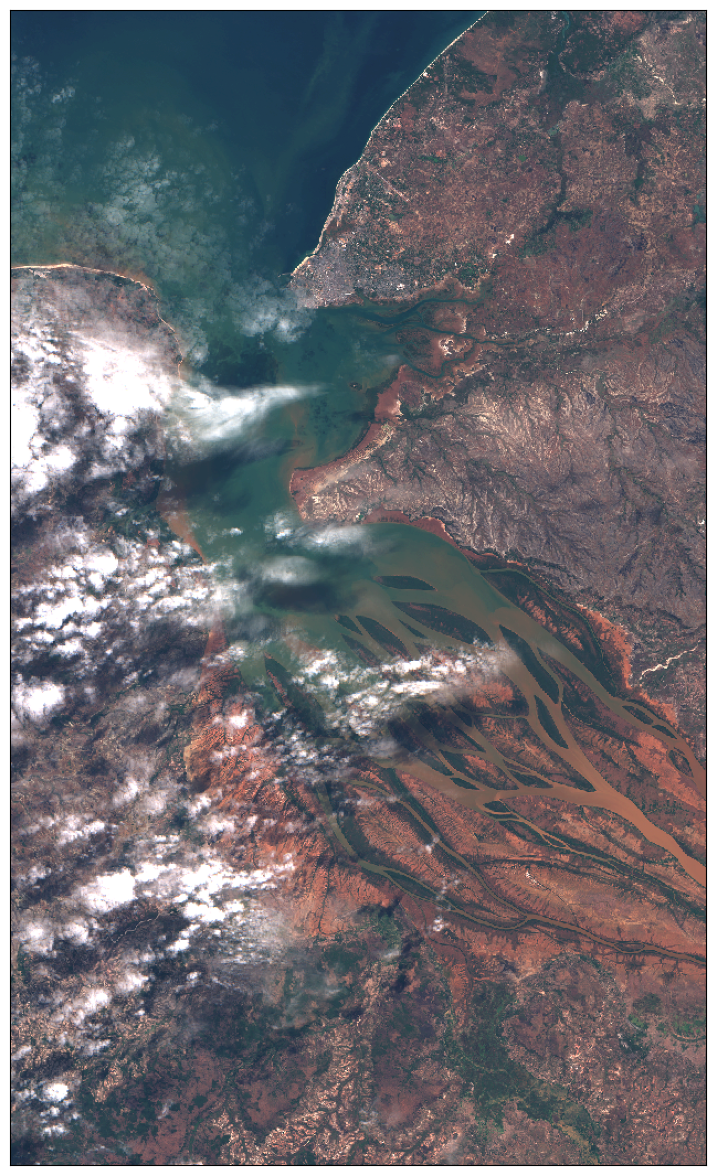

In [9]:
plot_image(true_color_imgs[0], factor=3.5 / 255, clip_range=(0, 1))